In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')
import time
import random
from tqdm import tqdm_notebook

# Fastai
from fastai import *
from fastai.tabular import *

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
os.getcwd()

# Any results you write to the current directory are saved as output.
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
sns.set(font_scale=1)

In [3]:
random_state = 2019
np.random.seed(random_state)
df_train = pd.read_csv('/storage/santander_comp/train.csv')
df_test = pd.read_csv('/storage/santander_comp/test.csv')

In [4]:
features = [feature for feature in df_train.columns if feature not in ['ID_code', 'target']]

In [5]:
# Min-Max Normalize
def normalize(df, features):
    result = df.copy()
    for feature in features:
        max_val = df[feature].max()
        min_val = df[feature].min()
        result[feature] = (df[feature] - min_val) / (max_val - min_val)
    return result

def z_norm(df, features):
    result = df.copy()
    for feature in features:
        std = np.std(df[feature])
        mean = np.mean(df[feature])
        result[feature] = (df[feature] - mean) / std
    return result

In [7]:
train_norm = normalize(df_train, features)

In [8]:
test_norm = normalize(df_test, features)

In [11]:
train_z_norm = z_norm(df_train, features)

In [13]:
test_z_norm = z_norm(df_test, features)

In [12]:
train_z_norm.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,-0.577102,-1.273737,0.451707,-0.833709,0.235571,-0.536430,-0.334926,0.608751,...,0.263374,-1.149158,0.817469,-0.411013,0.168705,-1.578117,1.022131,-0.373968,-1.026398,0.214135
1,train_1,0,0.269959,-0.622138,1.190360,-0.688846,0.790975,1.539900,0.244461,-0.003525,...,0.966611,0.093605,0.443623,1.908764,-0.817594,1.522342,1.067654,-0.129400,0.825417,0.505685
2,train_2,0,-0.681113,-0.276066,0.516988,0.536516,-0.305477,-0.511033,1.769839,-0.564749,...,-0.072093,0.777997,-0.174131,-0.412316,1.151591,2.297370,-1.617906,-0.695141,-0.381449,0.356681
3,train_3,0,0.125158,-0.129426,-0.667575,0.195355,0.927992,0.410672,0.500633,-0.474201,...,0.270216,-0.891456,-0.818468,-0.478548,1.607869,-0.789517,-0.959020,1.501744,0.697118,-0.543502
4,train_4,0,-0.277303,0.035610,0.817683,-0.077829,0.738607,0.955574,0.613372,0.791544,...,-1.036191,0.688988,-1.405987,1.468536,-1.501101,-0.958473,0.297627,0.645537,0.706318,-0.525375


In [6]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(10,10,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

In [91]:
trn_norm0 = train_norm.loc[train_norm['target'] == 0]
trn_norm1 = train_norm.loc[train_norm['target'] == 1]

In [12]:
train0 = df_train.loc[df_train['target'] == 0]
train1 = df_train.loc[df_train['target'] == 1]
feats1 = df_train.columns.values[2:102]
feats2 = df_train.columns.values[102:]

<Figure size 576x396 with 0 Axes>

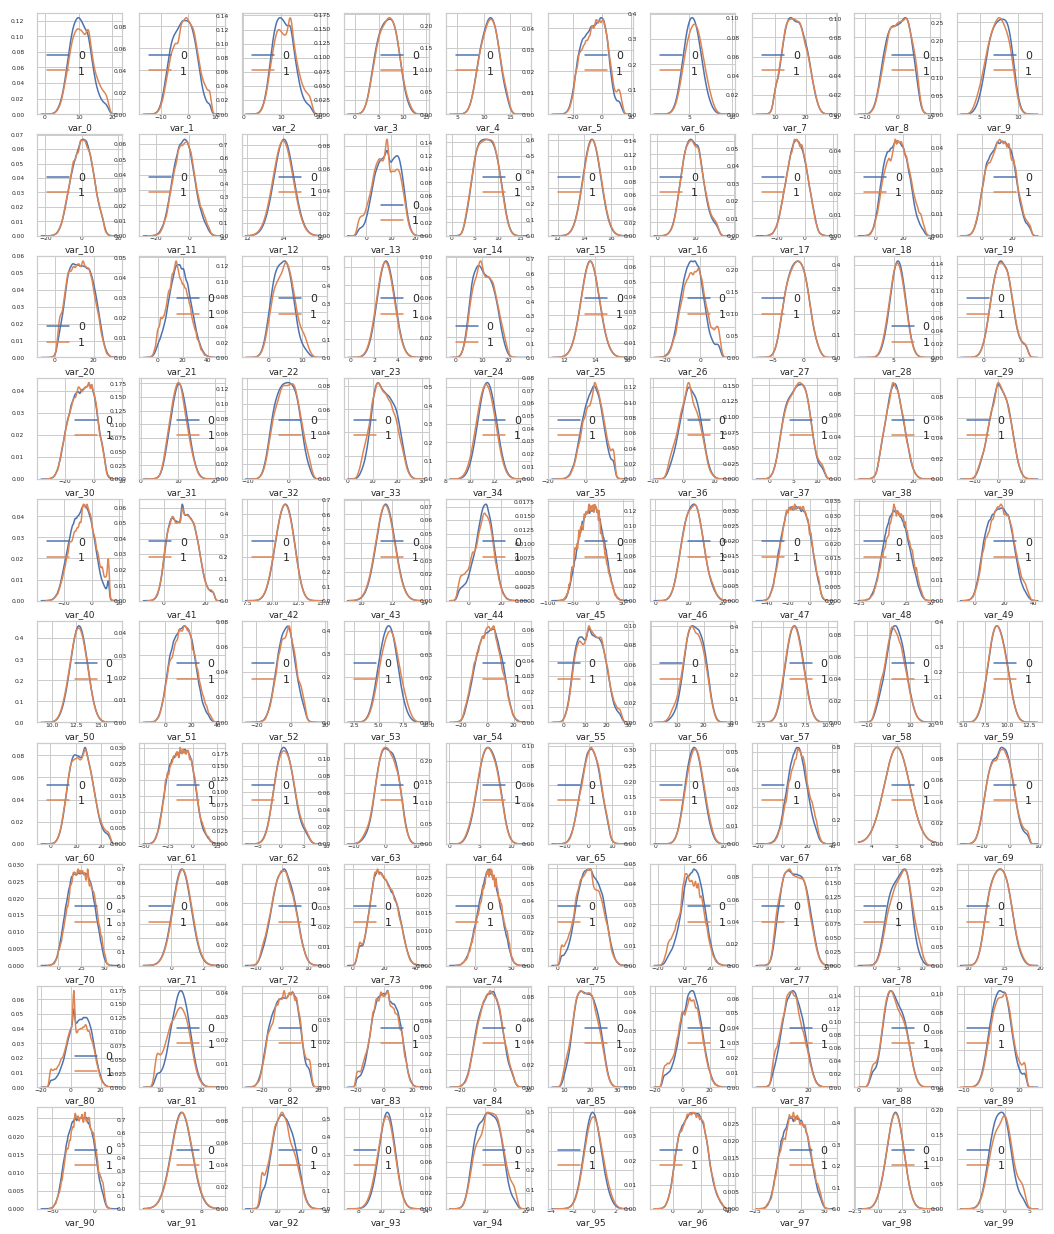

In [15]:
plot_feature_distribution(train0, train1, '0', '1', feats1)

In [17]:
df_train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


### Add Feature Interactions from uncorrelated probability distribution functions

In [38]:
print('var_%d' %10)

var_10


In [42]:
['var_%d' %x for x in (10, 17, 27, 30, 38, 41, 46, 100, 103, 124)]

['var_10',
 'var_17',
 'var_27',
 'var_30',
 'var_38',
 'var_41',
 'var_46',
 'var_100',
 'var_103',
 'var_124']

In [7]:
from sklearn.preprocessing import PolynomialFeatures

# Features with a PDF correlation of less than 0.15 are
# ....
# var_10, 17, 27, 30, 38, 41, 46, 100, 103, 124
poly_feats = df_train[['var_%d' %x for x in (10, 17, 27, 30, 38, 41, 46, 100, 103, 124)]]

poly = PolynomialFeatures(interaction_only=True)
p = poly.fit(poly_feats)

In [8]:
poly_feats_test = df_test[['var_%d' %x for x in (10, 17, 27, 30, 38, 41, 46, 100, 103, 124)]]
p = poly.fit(poly_feats_test)

In [9]:
print(p.get_feature_names(poly_feats.columns))

['1', 'var_10', 'var_17', 'var_27', 'var_30', 'var_38', 'var_41', 'var_46', 'var_100', 'var_103', 'var_124', 'var_10 var_17', 'var_10 var_27', 'var_10 var_30', 'var_10 var_38', 'var_10 var_41', 'var_10 var_46', 'var_10 var_100', 'var_10 var_103', 'var_10 var_124', 'var_17 var_27', 'var_17 var_30', 'var_17 var_38', 'var_17 var_41', 'var_17 var_46', 'var_17 var_100', 'var_17 var_103', 'var_17 var_124', 'var_27 var_30', 'var_27 var_38', 'var_27 var_41', 'var_27 var_46', 'var_27 var_100', 'var_27 var_103', 'var_27 var_124', 'var_30 var_38', 'var_30 var_41', 'var_30 var_46', 'var_30 var_100', 'var_30 var_103', 'var_30 var_124', 'var_38 var_41', 'var_38 var_46', 'var_38 var_100', 'var_38 var_103', 'var_38 var_124', 'var_41 var_46', 'var_41 var_100', 'var_41 var_103', 'var_41 var_124', 'var_46 var_100', 'var_46 var_103', 'var_46 var_124', 'var_100 var_103', 'var_100 var_124', 'var_103 var_124']


In [11]:
features = pd.DataFrame(p.transform(poly_feats), columns=p.get_feature_names(poly_feats.columns))

In [13]:
features_test = pd.DataFrame(p.transform(poly_feats_test), columns=p.get_feature_names(poly_feats_test.columns))

In [14]:
new_poly_feats = features.iloc[:, 11:]
new_poly_feats_test = features_test.iloc[:, 11:]

In [15]:
new_poly_feats.shape

(200000, 45)

In [16]:
new_poly_feats_test.shape

(200000, 45)

In [19]:
df_train = df_train.join(new_poly_feats)

In [20]:
df_test = df_test.join(new_poly_feats_test)

## Save polynomial_feature dataframes to csv. Also save 20% sample dataframes (for gridsearch) to csv

In [24]:
os.chdir('/storage/santander_comp/')
df_train.to_csv('train_poly.csv', index=False)
df_test.to_csv('test_poly.csv', index=False)

In [22]:
lgb_params = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : -1,
    "num_leaves" : 13,
    "num_threads": 8,
    "learning_rate" : 0.0085,
    "bagging_freq": 5,
    "bagging_fraction" : 0.4,
    "feature_fraction" : 0.04,
    "min_data_in_leaf": 80,
    "min_sum_heassian_in_leaf": 10,
    "tree_learner": "serial",
    "boost_from_average": "false",
    #"lambda_l1" : 5,
    #"lambda_l2" : 5,
    "bagging_seed" : random_state,
    "verbosity" : -1,
    "seed": random_state
}

In [ ]:
param_grid = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "num_leaves" : [13, 12, 11],
    "learning_rate" : 0.0085,
    "bagging_freq": [3,5],
    "bagging_fraction" : [0.3, 0.4, 0.5],
    "feature_fraction" : 0.04,
    "min_data_in_leaf": 80,
    "min_sum_heassian_in_leaf": 10,
    "tree_learner": "serial",
    "boost_from_average": "false",
    #"lambda_l1" : 5,
    #"lambda_l2" : 5,
    "bagging_seed" : random_state,
    "verbosity" : -1,
    "seed": random_state
}


In [90]:
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

In [94]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
oof = df_train[['ID_code', 'target']]
oof['predict'] = 0
predictions = df_train[['ID_code']]
val_aucs = []
feature_importance_df = pd.DataFrame()

In [91]:
features = [col for col in df_train.columns if col not in ['target', 'ID_code']]
# Using z-norm test and train
# X_test = test_z_norm[features].values

In [19]:
# df_train = train_z_norm
# df_test = test_z_norm

In [101]:
df_train_small = df_train.sample(frac = 0.2, axis = 0)

In [102]:
df_train_small.shape

(40000, 247)

In [103]:
X_test = df_test[features].values

In [98]:
df_test[features].head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_41 var_46,var_41 var_100,var_41 var_103,var_41 var_124,var_46 var_100,var_46 var_103,var_46 var_124,var_100 var_103,var_100 var_124,var_103 var_124
0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,...,229.871684,-174.038477,28.160112,18.281987,-112.275036,18.166544,11.794006,-13.754098,-8.929376,1.444808
1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,...,42.405855,-5.407826,5.192541,17.663727,-23.352518,22.422855,76.276952,-2.859485,-9.727253,9.340012
2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,8.3442,...,52.753425,-18.329177,7.284103,11.553157,-35.387949,14.063341,22.305559,-4.886308,-7.750066,3.079914
3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,7.4578,...,13.121750,1.626186,1.449628,4.118061,23.377152,20.839053,59.198953,2.582596,7.336562,6.540018
4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,7.1437,...,83.304376,-73.931503,7.387600,33.422273,-233.188064,23.301300,105.417513,-20.679588,-93.556612,9.348638


In [111]:
df_train = df_train_small

In [105]:
from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df_train.drop())

In [ ]:
X_train, y_train = df_train.iloc[trn_idx][features], df_train.iloc[trn_idx]['target']
X_valid, y_valid = df_train.iloc[val_idx][features], df_train.iloc[val_idx]['target']
    
p_valid,yp = 0,0
X_t, y_t = augment(X_train.values, y_train.values)
X_t = pd.DataFrame(X_t)
X_t = X_t.add_prefix('var_')
    
trn_data = lgb.Dataset(X_t, label=y_t)
val_data = lgb.Dataset(X_valid, label=y_valid)
evals_result = {}
lgb_clf = lgb.train(lgb_params,
                        trn_data,
                        100000,
                        valid_sets = [trn_data, val_data],
                        early_stopping_rounds=2000,
                        verbose_eval = 1000,
                        evals_result=evals_result
                       )
p_valid += lgb_clf.predict(X_valid)
yp += lgb_clf.predict(X_test)
fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = features
fold_importance_df["importance"] = lgb_clf.feature_importance()
fold_importance_df["fold"] = fold + 1
feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
oof['predict'][val_idx] = p_valid # /N
val_score = roc_auc_score(y_valid, p_valid)
val_aucs.append(val_score)
predictions['fold{}'.format(fold+1)] = yp # /N

In [99]:
for fold, (trn_idx, val_idx) in enumerate(skf.split(df_train, df_train['target'])):
    X_train, y_train = df_train.iloc[trn_idx][features], df_train.iloc[trn_idx]['target']
    X_valid, y_valid = df_train.iloc[val_idx][features], df_train.iloc[val_idx]['target']
    
    p_valid,yp = 0,0
    X_t, y_t = augment(X_train.values, y_train.values)
    X_t = pd.DataFrame(X_t)
    X_t = X_t.add_prefix('var_')
    
    trn_data = lgb.Dataset(X_t, label=y_t)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    evals_result = {}
    lgb_clf = lgb.train(lgb_params,
                        trn_data,
                        100000,
                        valid_sets = [trn_data, val_data],
                        early_stopping_rounds=2000,
                        verbose_eval = 1000,
                        evals_result=evals_result
                       )
    p_valid += lgb_clf.predict(X_valid)
    yp += lgb_clf.predict(X_test)
#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["feature"] = features
#     fold_importance_df["importance"] = lgb_clf.feature_importance()
#     fold_importance_df["fold"] = fold + 1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    oof['predict'][val_idx] = p_valid # /N
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)
    predictions['fold{}'.format(fold+1)] = yp # /N

Training until validation scores don't improve for 2000 rounds.
[1000]	training's auc: 0.898301	valid_1's auc: 0.885748
[2000]	training's auc: 0.905366	valid_1's auc: 0.891201
[3000]	training's auc: 0.910123	valid_1's auc: 0.894085
[4000]	training's auc: 0.9142	valid_1's auc: 0.896147
[5000]	training's auc: 0.91754	valid_1's auc: 0.897463
[6000]	training's auc: 0.92057	valid_1's auc: 0.898301
[7000]	training's auc: 0.923225	valid_1's auc: 0.898794
[8000]	training's auc: 0.925781	valid_1's auc: 0.899194
[9000]	training's auc: 0.928203	valid_1's auc: 0.899391
[10000]	training's auc: 0.930648	valid_1's auc: 0.899475
[11000]	training's auc: 0.932908	valid_1's auc: 0.899539
[12000]	training's auc: 0.935134	valid_1's auc: 0.899536
[13000]	training's auc: 0.937278	valid_1's auc: 0.899473
Early stopping, best iteration is:
[11264]	training's auc: 0.9335	valid_1's auc: 0.899571
Training until validation scores don't improve for 2000 rounds.
[1000]	training's auc: 0.897322	valid_1's auc: 0.88962

In [115]:
# for fold, (trn_idx, val_idx) in enumerate(skf.split(df_train, df_train['target'])):
#     X_train, y_train = df_train.iloc[trn_idx][features], df_train.iloc[trn_idx]['target']
#     X_valid, y_valid = df_train.iloc[val_idx][features], df_train.iloc[val_idx]['target']
    
#     N = 5
#     p_valid,yp = 0,0
#     for i in range(N):
#         X_t, y_t = augment(X_train.values, y_train.values)
#         X_t = pd.DataFrame(X_t)
#         X_t = X_t.add_prefix('var_')
    
#         trn_data = lgb.Dataset(X_t, label=y_t)
#         val_data = lgb.Dataset(X_valid, label=y_valid)
#         evals_result = {}
#         lgb_clf = lgb.train(lgb_params,
#                         trn_data,
#                         100000,
#                         valid_sets = [trn_data, val_data],
#                         early_stopping_rounds=3000,
#                         verbose_eval = 1000,
#                         evals_result=evals_result
#                        )
#         p_valid += lgb_clf.predict(X_valid)
#         yp += lgb_clf.predict(X_test)
#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["feature"] = features
#     fold_importance_df["importance"] = lgb_clf.feature_importance()
#     fold_importance_df["fold"] = fold + 1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
#     oof['predict'][val_idx] = p_valid # /N
#     val_score = roc_auc_score(y_valid, p_valid)
#     val_aucs.append(val_score)
    
#     predictions['fold{}'.format(fold+1)] = yp # /N

In [100]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['target'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Mean auc: 0.900274049, std: 0.003283189. All auc: 0.900094554.


In [24]:
predictions['target'] = np.mean(predictions[[col for col in predictions.columns if col not in ['ID_code', 'target']]].values, axis=1)
predictions.to_csv('lgb_all_predictions.csv', index=None)
sub_df = pd.DataFrame({"ID_code":df_test["ID_code"].values})
sub_df["target"] = predictions['target']
sub_df.to_csv("lgb_submission.csv", index=False)

In [26]:
!kaggle competitions submit -c santander-customer-transaction-prediction -f lgb_submission.csv -m "Message"

100%|######################################| 6.03M/6.03M [00:00<00:00, 7.99MB/s]
Successfully submitted to Santander Customer Transaction Prediction